# Cosmology sampling of cosmographic posteriors
This notebook leads you through a sampling of multiple lenses with two dimensional angular diameter distance posteriors.
We first generate a set of posteriors for different lenses for a given cosmology and then sample cosmological model posteriors from this generated mock data set.

In [1]:
# some standard python imports #
import copy
import numpy as np
import corner
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed=41)

In [2]:
# lenstronomy and astropy modules

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Cosmo.Sampling.mcmc_sampling import MCMCSampler
from astropy.cosmology import FlatLambdaCDM

# define a cosmology
H0_true = 70
omega_m_true = 0.3
cosmo = FlatLambdaCDM(H0=H0_true, Om0=omega_m_true)

In [3]:
# define lenses and their uncertainties in the posterior (uncorrelated)
lens_setting_list = [{'z_lens': 0.8, 'z_source': 3.0, 'sigma_dt': 0.07, 'sigma_dd': 0.15},
                     {'z_lens': 0.3, 'z_source': 1.1, 'sigma_dt': 0.07, 'sigma_dd': 0.15},
                     {'z_lens': 0.5, 'z_source': 1.7, 'sigma_dt': 0.07, 'sigma_dd': 0.15}
                    ]

bandwidth = 2
num_samples = 10000  # number of posterior points to be sampled
kde_type = 'scipy_gaussian'  # 'gaussian', 'epanechnikov', 'scipy_gaussian'

kwargs_lens_list = []
for lens_setting in lens_setting_list:
    z_lens = lens_setting['z_lens']
    z_source = lens_setting['z_source']
    sigma_dd = lens_setting['sigma_dd']
    sigma_dt = lens_setting['sigma_dt']
    lensCosmo = LensCosmo(z_lens, z_source, cosmo=cosmo)

    Dd_mean = np.random.normal(lensCosmo.D_d, sigma_dd * lensCosmo.D_d)
    Ddt_mean = np.random.normal(lensCosmo.D_dt, sigma_dt * lensCosmo.D_dt)

    
    D_dt_samples = np.random.normal(Ddt_mean, sigma_dt * lensCosmo.D_dt, num_samples)
    D_d_samples = np.random.normal(Dd_mean, sigma_dd * lensCosmo.D_d, num_samples)
    kwargs_lens_list.append({'z_lens': z_lens, 'z_source': z_source, 'D_d_sample': D_d_samples,
                       'D_delta_t_sample': D_dt_samples, 'kde_type': kde_type, 'bandwidth': bandwidth})

/Users/sibirrer/Software/lenstronomy/lenstronomy/Cosmo/kde_likelihood.py:43: RuntimeWarning: divide by zero encountered in log
  logL = np.log(density)
100%|██████████| 400/400 [02:01<00:00,  3.37it/s]


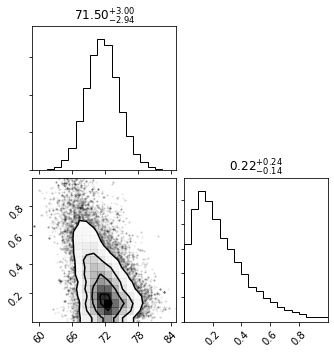

In [4]:

cosmology = 'FLCDM'  # available models: 'FLCDM', "FwCDM", "w0waCDM", "oLCDM"

# parameters are: 'h0', 'om', 'ok', 'w', 'w0', 'wa'

# there is also the option to sample the post-newtonian parameter gamma_ppn
kwargs_lower = {'h0': 1, 'om': 0}
kwargs_upper = {'h0': 200, 'om': 1}
kwargs_fixed = {}
mcmc_sampler = MCMCSampler(kwargs_lens_list, cosmology, kwargs_lower, kwargs_upper, kwargs_fixed)
n_walkers = 200
n_run = 200
n_burn = 200
kwargs_mean_start = {'h0': 70, 'om': 0.3}
kwargs_sigma_start = {'h0': 10, 'om': 0.1}

mcmc_samples_cosmo_narrow = mcmc_sampler.mcmc_emcee(n_walkers, n_run, n_burn, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_cosmo_narrow, show_titles=True)
plt.show()